In [8]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, roc_auc_score)
from sklearn.impute import SimpleImputer
import pickle
from mlreg_client import Ml_registry


<h2> Cargar el fichero

In [9]:
FILE = 'demo_file.csv'
target = 'Y'

df =pd.read_csv(FILE)
print(df.shape)
print(df.columns)

(1969, 8)
Index(['FILTRO', 'AGR_FECHA', 'Y', 'max_sal_cre_top_cnv_con_rcc_u12m_T',
       'sow_cre_top_sie_con_rcc_m1', 'med_sow_cre_top_cnv_rcc_u3m',
       'sumprm_sal_cre_defdudper_rcc_u12m', 'BASE DETALLE'],
      dtype='object')


In [10]:
var_list = ['max_sal_cre_top_cnv_con_rcc_u12m_T',
            'sow_cre_top_sie_con_rcc_m1', 
            'med_sow_cre_top_cnv_rcc_u3m',
            'sumprm_sal_cre_defdudper_rcc_u12m']

X = df[var_list]
y = df[target]

print(X.dtypes)
print(y.shape)

# Split the data into training and testing sets



max_sal_cre_top_cnv_con_rcc_u12m_T    float64
sow_cre_top_sie_con_rcc_m1            float64
med_sow_cre_top_cnv_rcc_u3m           float64
sumprm_sal_cre_defdudper_rcc_u12m     float64
dtype: object
(1969,)


In [14]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Este codigp NO va functionar porque el dataset tiene missing values!!!
lr =LogisticRegression()
lr.fit(X_train, y_train)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [16]:
imputer = SimpleImputer(strategy='median')

X_train_no_miss = imputer.fit_transform(X_train)


In [17]:
imputer.__dict__

{'missing_values': nan,
 'add_indicator': False,
 'keep_empty_features': False,
 'strategy': 'median',
 'fill_value': None,
 'copy': True,
 'feature_names_in_': array(['max_sal_cre_top_cnv_con_rcc_u12m_T', 'sow_cre_top_sie_con_rcc_m1',
        'med_sow_cre_top_cnv_rcc_u3m', 'sumprm_sal_cre_defdudper_rcc_u12m'],
       dtype=object),
 'n_features_in_': 4,
 '_fit_dtype': dtype('float64'),
 'indicator_': None,
 'statistics_': array([2.70503900e+04, 5.85871898e-01, 8.50216209e-01, 0.00000000e+00])}

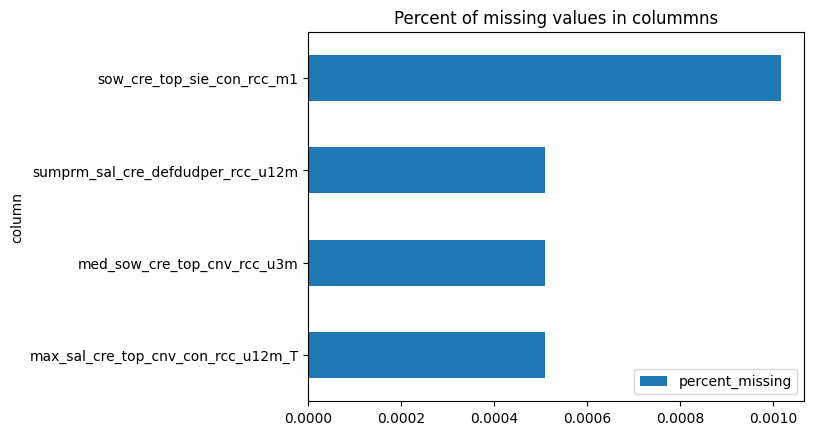

In [18]:
import matplotlib.pyplot as plt
def plot_missing_values(df):
    """ For each column with missing values plot proportion that is missing."""
    data = [(col, df[col].isnull().sum() / len(df)) 
            for col in df.columns if df[col].isnull().sum() > 0]
    col_names = ['column', 'percent_missing']
    missing_df = pd.DataFrame(data, columns=col_names).sort_values('percent_missing')
    
    missing_df.plot(kind='barh', x='column', y='percent_missing'); 
    plt.title('Percent of missing values in colummns');
plot_missing_values(df[var_list])

In [19]:
from sklearn.pipeline import Pipeline



model = Pipeline([
    ('Replace Missing', SimpleImputer(strategy='median')),
    ('estimator' , LogisticRegression())
    ])


# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

auc= roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("AUC:",auc)

pred = pd.DataFrame(model.predict_proba(X))
pd.concat([pred.reset_index(drop=True),y.reset_index(drop=True)],axis=1)

Accuracy: 0.9670050761421319
AUC: 0.6695941853422168


,0,1,Y
0,0.956191,0.043809,0
1,0.968430,0.031570,0
2,0.976195,0.023805,0
3,0.946046,0.053954,1
4,0.989635,0.010365,0
...,...,...,...
1964,0.966737,0.033263,0
1965,0.958520,0.041480,0
1966,0.964876,0.035124,0
1967,0.936546,0.063454,0


<h2>Gardar el modelo en un pickle para usarlo en el scoring

In [20]:
MODEL_PICKLE_NAME = "model.pickle"

with open(MODEL_PICKLE_NAME, "wb") as output_file:
    pickle.dump(model, output_file)

<h3> Fin de la parte 1 de creation de la primera version del modelo</h3>
Copiar de manera manual (copy/paste) el pickle hacia el microservicio de scoring

<h2>------------------------------------------

<h2> Parte 1a  Registrar el modelo en el Model Registry</h2>
Al lugar de copiar de manera manual el pickle en el micro servicio de scoring 

In [13]:
MODEL_NAME = "Logistic Pipeline"
MODEL_DESCRIPTION = "Modelo simple para demo"
TARGET_DESC = "Probabilidad default"

VARIABLES = ', '.join(f"'{i}'" for i in var_list)


data = {"model_name": MODEL_NAME,
            "model_description": MODEL_DESCRIPTION,
            "version_name":'Logistic regression v1',
            "version_description" : MODEL_DESCRIPTION,
         
            "parameters" : "'type': 'logistic','Feature selection':'None'",
            "variables": VARIABLES,
            "target_desc":TARGET_DESC
          }


ml_r = Ml_registry(company_id=3, user_id=1,bucket_name='modelfactorymarcos',bucket_folder = 'demo_septiembre',client_secret='/Users/marcosdurbano/Documents/marcos/python/demo_mlops/secret/client_secret.json')

r = ml_r.create_model_version(**data)
ml_r.upload_model(MODEL_PICKLE_NAME)
model_id = ml_r.get_model_by_name(MODEL_NAME).get('data').get('id')
ml_r.change_status(r.get('model_id'),r.get('version'),status='PROD')

# Agregar los resultados de la validaccion

from datetime import date
today = date.today().strftime('%Y-%m-%d')
version_id= r.get('version_id')

ml_r.track_version( version_id, today, 'AUC', str(auc))
ml_r.track_version( version_id, today, 'Accuracy', str(accuracy))


INFO:root:Sending this data {'model_name': 'Logistic Pipeline', 'model_description': 'Modelo simple para demo', 'version_name': 'Logistic regression v1', 'version_description': 'Modelo simple para demo', 'version_parameters': "'type': 'logistic','Feature selection':'None'", 'variables': "'max_sal_cre_top_cnv_con_rcc_u12m_T', 'sow_cre_top_sie_con_rcc_m1', 'med_sow_cre_top_cnv_rcc_u3m', 'sumprm_sal_cre_defdudper_rcc_u12m'", 'user_id': 1, 'company_id': 3, 'bucket_folder': 'demo_septiembre', 'pipeline_id': None, 'target_desc': 'Probabilidad default'}


INFO:root:The artifacts path is 'demo_septiembre/Logistic Pipeline/v3/'
INFO:root:uploading 'model_rf.pickle' to demo_septiembre/Logistic Pipeline/v3/model.pkl
INFO:root:Sending this data {'version_id': 3, 'status': 'PROD'}
INFO:root:Sending this data {'user_id': 1, 'validation_dt': '2023-09-25', 'stat_name': 'AUC', 'data': '0.5624873813850192'}
INFO:root:Sending this data {'user_id': 1, 'validation_dt': '2023-09-25', 'stat_name': 'ACCURACY', 'data': '0.9619289340101523'}


{'message': 'Updated version 3 to PROD'}


{'message': 'New ACCURACY recorded for version 3 '}

<h2> Crear una y ponerla en el ML Registry

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_rf = Pipeline([
    ('Replace Missing', SimpleImputer(strategy='median')),
    ('estimator' , RandomForestClassifier())
    ])


# Train the model on the training data
model_rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model_rf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

auc= roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1])
print("AUC:",auc)

pred = pd.DataFrame(model_rf.predict_proba(X))
pd.concat([pred.reset_index(drop=True),y.reset_index(drop=True)],axis=1)

Accuracy: 0.9619289340101523
AUC: 0.5624873813850192


,0,1,Y
0,0.99,0.01,0
1,0.99,0.01,0
2,0.99,0.01,0
3,0.29,0.71,1
4,1.00,0.00,0
...,...,...,...
1964,1.00,0.00,0
1965,1.00,0.00,0
1966,1.00,0.00,0
1967,1.00,0.00,0


In [10]:
MODEL_PICKLE_NAME = "model_rf.pickle"

with open(MODEL_PICKLE_NAME, "wb") as output_file:
    pickle.dump(model_rf, output_file)

Poner la version 2 en el model Registry


In [11]:
MODEL_NAME = "Logistic Pipeline"
MODEL_DESCRIPTION = "Modelo simple para demo"
TARGET_DESC = "Probabilidad default"

VARIABLES = ', '.join(f"'{i}'" for i in var_list)


data = {"model_name": MODEL_NAME,
            "model_description": MODEL_DESCRIPTION,
            "version_name":'Random Forest test',
            "version_description" : MODEL_DESCRIPTION,
         
            "parameters" : "'type': 'RF','Feature selection':'None'",
            "variables": VARIABLES,
            "target_desc":TARGET_DESC
          }


ml_r = Ml_registry(company_id=3, user_id=1,bucket_name='modelfactorymarcos',bucket_folder = 'demo_septiembre',client_secret='/Users/marcosdurbano/Documents/marcos/python/demo_mlops/secret/client_secret.json')

r = ml_r.create_model_version(**data)
ml_r.upload_model("model_rf.pickle")
model_id = ml_r.get_model_by_name(MODEL_NAME).get('data').get('id')
ml_r.change_status(r.get('model_id'),r.get('version'),status='PROD')

INFO:root:Sending this data {'model_name': 'Logistic Pipeline', 'model_description': 'Modelo simple para demo', 'version_name': 'Random Forest test', 'version_description': 'Modelo simple para demo', 'version_parameters': "'type': 'RF','Feature selection':'None'", 'variables': "'max_sal_cre_top_cnv_con_rcc_u12m_T', 'sow_cre_top_sie_con_rcc_m1', 'med_sow_cre_top_cnv_rcc_u3m', 'sumprm_sal_cre_defdudper_rcc_u12m'", 'user_id': 1, 'company_id': 3, 'bucket_folder': 'demo_septiembre', 'pipeline_id': None, 'target_desc': 'Probabilidad default'}


INFO:root:The artifacts path is 'demo_septiembre/Logistic Pipeline/v2/'
INFO:root:uploading 'model_rf.pickle' to demo_septiembre/Logistic Pipeline/v2/model.pkl
INFO:root:Sending this data {'version_id': 2, 'status': 'PROD'}


{'message': 'Updated version 2 to PROD'}
